In [115]:
from collections import Counter
from gensim.corpora import Dictionary
from nltk import ngrams

import itertools
import numpy as np
import os
import pybo

import matplotlib.pyplot as plt
%matplotlib inline

Store texts in the following directory structure:

    texts
      Bon
        file1.txt
        file2.txt
        ...
      Nyingma
        file1.txt
        file2.txt
        ...

In [2]:
tok = pybo.BoTokenizer('POS')

Loading Trie...
Time: 4.416924953460693


Assumptions here:
1. Drop all non-bo text
2. Drop all phrase delimiters (shad)
3. Reduce words to lemmas
4. Strip beginning and ending tseks from lemmas

In [82]:
tsek = '་'

# Create dictionary to map document index back to filename
bon_idx2fname = {}
bon_texts = []
for filename in sorted(os.listdir("texts/Bon")):
    if ".txt" in filename:
        with open("texts/Bon/" + filename, 'r', encoding='utf-8-sig') as f:
            bon_idx2fname[len(bon_texts)] = filename
            tokens = [t for t in tok.tokenize(f.read()) if t.type != "non-bo" and t.pos != "punct"]
            lemmas = [t.lemma.strip(tsek) if t.lemma else t.content.strip(tsek) for t in tokens]
            bon_texts.append(lemmas)
            
# Now process nyingma
nyingma_idx2fname = {}
nyingma_texts = []
for filename in sorted(os.listdir("texts/Nyingma")):
    if ".txt" in filename:
        with open("texts/Nyingma/" + filename, 'r', encoding='utf-8-sig') as f:
            nyingma_idx2fname[len(nyingma_texts)] = filename
            tokens = [t for t in tok.tokenize(f.read()) if t.type != "non-bo" and t.pos != "punct"]
            lemmas = [t.lemma.strip(tsek) if t.lemma else t.content.strip(tsek) for t in tokens]
            nyingma_texts.append(lemmas)

## Part 1a: Pairwise cosine similarity of term frequency vectors

In [83]:
dct = Dictionary(bon_texts + nyingma_texts)

In [84]:
bon_bows = []
for t in bon_texts:
    bon_bows.append(dct.doc2bow(t))
    
nyingma_bows = []
for t in nyingma_texts:
    nyingma_bows.append(dct.doc2bow(t))

In [85]:
bon_tfs = []
for t in bon_bows:
    vec = np.zeros(len(dct))
    for k, v in t:
        vec[k] = v
    bon_tfs.append(vec)
    
nyingma_tfs = []
for t in nyingma_bows:
    vec = np.zeros(len(dct))
    for k, v in t:
        vec[k] = v
    nyingma_tfs.append(vec)

In [86]:
cos_sims = np.zeros((len(bon_tfs), len(nyingma_tfs)))

for i in range(len(bon_tfs)):
    for j in range(len(nyingma_tfs)):
        u = bon_tfs[i]
        v = nyingma_tfs[j]
        cos_sims[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

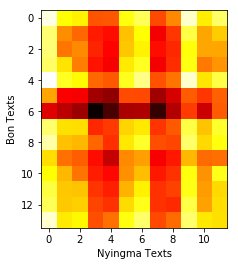

In [87]:
plt.imshow(cos_sims, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

Legend:

In [88]:
bon_idx2fname

{0: '01-SMDG-gser-lung-non-che.txt',
 1: '02-SMDG-gser-lung-non-chung.txt',
 2: '03-SMDG-sems-phran-rig-pa-khu-byug-sa-gcod.txt',
 3: '04-SMDG-rig-pa-khu-byug-gzhung.txt',
 4: '05-SMDG-rig-pa-khu-byug-grel.txt',
 5: '06-SMDG-cog-bzhag-sa-gcod.txt',
 6: '07-SMDG-cog-bzhag-gzhung.txt',
 7: '08-SMDG-cog-bzhag-grel.txt',
 8: '09-SMDG-rgyun-thag-sa-gcod-gzhung-grel.txt',
 9: '10-SMDG-sems-lung-rgyun-thag.txt',
 10: '11-SMDG-snang-dngos-med-mdzub-tshugs.txt',
 11: '12-SMDG-sgron-ma-gsal-ba.txt',
 12: "13-ngang-thag-bskal-pa'i-sgron-ma_TTN-175-195.txt",
 13: '14-SMDG-thig-le-dbyings-kyi-ti-ka.txt'}

In [89]:
nyingma_idx2fname

{0: 'LL01_L14_rtse-mo-byung-rgyal_vol8-p480-491.txt',
 1: "LL02_་nam-mkha'-rgyal-po_vol8-v475-480.txt",
 2: 'LL03_L16_bde-ba-phra-bkod_V8-p.495-498.txt',
 3: 'LL04_byang-chub-sems-tig.txt',
 4: "LL06_L15_bde-ba-rab-'byams_vol8-p.473-475-not-sure.txt",
 5: "LL07_L10_srog-gi-'khor-lo_v8.p491-494.txt",
 6: 'LL08_thig-le-drug-pa-NGB-vol33.txt',
 7: 'LL09_spyi-gcod_vol8_p.498.txt',
 8: 'LL10_yid-bzhin-nor-bu-431.txt',
 9: "LL11_kun-'dus-NGB-mtshams-brag-vol1-624-626་.txt",
 10: 'LL12_rje-btsan-dam-pa_NGB-vol34-p63-64.txt',
 11: 'LL13-sgom-pa-don-grubdocx.txt'}

## Part 1b: Pairwise cosine similarity of term frequency vectors (filtered)

In [90]:
scrap_list = ['གི','ལ','གིས','དང','ནི','ནས','པ','གོ','ཀྱང','དུ','ཀྱིས','དེ','ཏེ','མ','སྟེ','སུ','ཀྱི','གྱིས','ན','ཅེས','འདི','གྱི','ཅི','བ','པར','ཡིས','ཅིང','མོ','ཅེས་པ','རྣམས','ཏུ']

bon_texts_f = []
for t in bon_texts:
    t_f = [x for x in t if x not in scrap_list]
    bon_texts_f.append(t_f)

nyingma_texts_f = []
for t in nyingma_texts:
    t_f = [x for x in t if x not in scrap_list]
    nyingma_texts_f.append(t_f)

In [91]:
dct_f = Dictionary(bon_texts_f + nyingma_texts_f)

In [92]:
bon_bows_f = []
for t in bon_texts_f:
    bon_bows_f.append(dct_f.doc2bow(t))
    
nyingma_bows_f = []
for t in nyingma_texts_f:
    nyingma_bows_f.append(dct_f.doc2bow(t))

In [93]:
bon_tfs_f = []
for t in bon_bows_f:
    vec = np.zeros(len(dct))
    for k, v in t:
        vec[k] = v
    bon_tfs_f.append(vec)
    
nyingma_tfs_f = []
for t in nyingma_bows_f:
    vec = np.zeros(len(dct))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_f.append(vec)

In [94]:
cos_sims_f = np.zeros((len(bon_tfs_f), len(nyingma_tfs_f)))

for i in range(len(bon_tfs_f)):
    for j in range(len(nyingma_tfs_f)):
        u = bon_tfs_f[i]
        v = nyingma_tfs_f[j]
        cos_sims_f[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

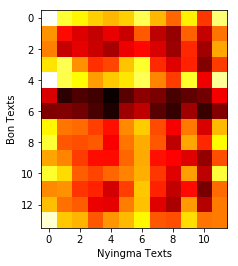

In [95]:
plt.imshow(cos_sims_f, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

Legend:

In [96]:
bon_idx2fname

{0: '01-SMDG-gser-lung-non-che.txt',
 1: '02-SMDG-gser-lung-non-chung.txt',
 2: '03-SMDG-sems-phran-rig-pa-khu-byug-sa-gcod.txt',
 3: '04-SMDG-rig-pa-khu-byug-gzhung.txt',
 4: '05-SMDG-rig-pa-khu-byug-grel.txt',
 5: '06-SMDG-cog-bzhag-sa-gcod.txt',
 6: '07-SMDG-cog-bzhag-gzhung.txt',
 7: '08-SMDG-cog-bzhag-grel.txt',
 8: '09-SMDG-rgyun-thag-sa-gcod-gzhung-grel.txt',
 9: '10-SMDG-sems-lung-rgyun-thag.txt',
 10: '11-SMDG-snang-dngos-med-mdzub-tshugs.txt',
 11: '12-SMDG-sgron-ma-gsal-ba.txt',
 12: "13-ngang-thag-bskal-pa'i-sgron-ma_TTN-175-195.txt",
 13: '14-SMDG-thig-le-dbyings-kyi-ti-ka.txt'}

In [97]:
nyingma_idx2fname

{0: 'LL01_L14_rtse-mo-byung-rgyal_vol8-p480-491.txt',
 1: "LL02_་nam-mkha'-rgyal-po_vol8-v475-480.txt",
 2: 'LL03_L16_bde-ba-phra-bkod_V8-p.495-498.txt',
 3: 'LL04_byang-chub-sems-tig.txt',
 4: "LL06_L15_bde-ba-rab-'byams_vol8-p.473-475-not-sure.txt",
 5: "LL07_L10_srog-gi-'khor-lo_v8.p491-494.txt",
 6: 'LL08_thig-le-drug-pa-NGB-vol33.txt',
 7: 'LL09_spyi-gcod_vol8_p.498.txt',
 8: 'LL10_yid-bzhin-nor-bu-431.txt',
 9: "LL11_kun-'dus-NGB-mtshams-brag-vol1-624-626་.txt",
 10: 'LL12_rje-btsan-dam-pa_NGB-vol34-p63-64.txt',
 11: 'LL13-sgom-pa-don-grubdocx.txt'}

## Part 2a: Pairwise cosine similarity of 2-gram frequency vectors

In [98]:
bon_bigrams = []
for t in bon_texts:
    grams = [tsek.join(x) for x in ngrams(t, 2)]
    bon_bigrams.append(grams)
    
nyingma_bigrams = []
for t in nyingma_texts:
    grams = [tsek.join(x) for x in ngrams(t, 2)]
    nyingma_bigrams.append(grams)

In [99]:
dct_bigrams = Dictionary(bon_bigrams + nyingma_bigrams)

In [100]:
bon_bows_bigrams = []
for t in bon_bigrams:
    bon_bows_bigrams.append(dct_bigrams.doc2bow(t))
    
nyingma_bows_bigrams = []
for t in nyingma_bigrams:
    nyingma_bows_bigrams.append(dct_bigrams.doc2bow(t))

In [101]:
bon_tfs_bigrams = []
for t in bon_bows_bigrams:
    vec = np.zeros(len(dct_bigrams))
    for k, v in t:
        vec[k] = v
    bon_tfs_bigrams.append(vec)
    
nyingma_tfs_bigrams = []
for t in nyingma_bows_bigrams:
    vec = np.zeros(len(dct_bigrams))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_bigrams.append(vec)

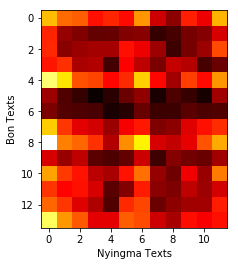

In [102]:
cos_sims_bigrams = np.zeros((len(bon_tfs_bigrams), len(nyingma_tfs_bigrams)))

for i in range(len(bon_tfs_bigrams)):
    for j in range(len(nyingma_tfs_bigrams)):
        u = bon_tfs_bigrams[i]
        v = nyingma_tfs_bigrams[j]
        cos_sims_bigrams[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

plt.imshow(cos_sims_bigrams, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

## Part 2b: Pairwise cosine similarity of 2-gram frequency vectors (filtered)

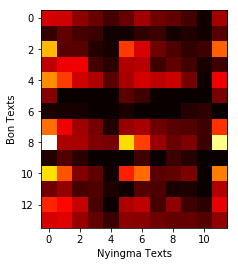

In [103]:
bon_bigrams_f = []
for t in bon_texts:
    grams = [tsek.join(x) for x in ngrams(t, 2) if not set(x).intersection(scrap_list)]
    bon_bigrams_f.append(grams)
    
nyingma_bigrams_f = []
for t in nyingma_texts:
    grams = [tsek.join(x) for x in ngrams(t, 2) if not set(x).intersection(scrap_list)]
    nyingma_bigrams_f.append(grams)
    
dct_bigrams_f = Dictionary(bon_bigrams_f + nyingma_bigrams_f)

bon_bows_bigrams_f = []
for t in bon_bigrams_f:
    bon_bows_bigrams_f.append(dct_bigrams_f.doc2bow(t))
    
nyingma_bows_bigrams_f = []
for t in nyingma_bigrams_f:
    nyingma_bows_bigrams_f.append(dct_bigrams_f.doc2bow(t))
    
bon_tfs_bigrams_f = []
for t in bon_bows_bigrams_f:
    vec = np.zeros(len(dct_bigrams_f))
    for k, v in t:
        vec[k] = v
    bon_tfs_bigrams_f.append(vec)
    
nyingma_tfs_bigrams_f = []
for t in nyingma_bows_bigrams_f:
    vec = np.zeros(len(dct_bigrams_f))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_bigrams_f.append(vec)

cos_sims_bigrams_f = np.zeros((len(bon_tfs_bigrams_f), len(nyingma_tfs_bigrams_f)))

for i in range(len(bon_tfs_bigrams_f)):
    for j in range(len(nyingma_tfs_bigrams_f)):
        u = bon_tfs_bigrams_f[i]
        v = nyingma_tfs_bigrams_f[j]
        cos_sims_bigrams_f[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

plt.imshow(cos_sims_bigrams_f, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

## Part 3a: Pairwise cosine similarity of word + 2-gram frequency

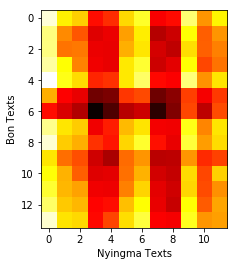

In [104]:
bon_words_bigrams = []
for t1, t2 in zip(bon_texts, bon_bigrams):
    bon_words_bigrams.append(t1 + t2)
    
nyingma_words_bigrams = []
for t1, t2 in zip(nyingma_texts, nyingma_bigrams):
    nyingma_words_bigrams.append(t1 + t2)
    
dct_words_bigrams = Dictionary(nyingma_words_bigrams + nyingma_words_bigrams)

bon_bows_words_bigrams = []
for t in bon_words_bigrams:
    bon_bows_words_bigrams.append(dct_words_bigrams.doc2bow(t))
    
nyingma_bows_words_bigrams = []
for t in nyingma_words_bigrams:
    nyingma_bows_words_bigrams.append(dct_words_bigrams.doc2bow(t))
    
bon_tfs_words_bigrams = []
for t in bon_bows_words_bigrams:
    vec = np.zeros(len(dct_words_bigrams))
    for k, v in t:
        vec[k] = v
    bon_tfs_words_bigrams.append(vec)
    
nyingma_tfs_words_bigrams = []
for t in nyingma_bows_words_bigrams:
    vec = np.zeros(len(dct_words_bigrams))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_words_bigrams.append(vec)

cos_sims_words_bigrams = np.zeros((len(bon_tfs_words_bigrams), len(nyingma_tfs_words_bigrams)))

for i in range(len(bon_tfs_words_bigrams)):
    for j in range(len(nyingma_tfs_words_bigrams)):
        u = bon_tfs_words_bigrams[i]
        v = nyingma_tfs_words_bigrams[j]
        cos_sims_words_bigrams[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

plt.imshow(cos_sims_words_bigrams, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

## Part 3b: Pairwise cosine similarity of word + 2-gram frequency

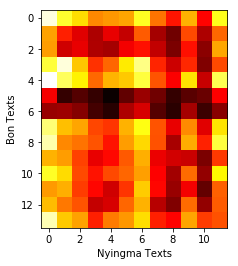

In [105]:
bon_words_bigrams_f = []
for t1, t2 in zip(bon_texts_f, bon_bigrams_f):
    bon_words_bigrams_f.append(t1 + t2)
    
nyingma_words_bigrams_f = []
for t1, t2 in zip(nyingma_texts_f, nyingma_bigrams_f):
    nyingma_words_bigrams_f.append(t1 + t2)
    
dct_words_bigrams_f = Dictionary(nyingma_words_bigrams_f + nyingma_words_bigrams_f)

bon_bows_words_bigrams_f = []
for t in bon_words_bigrams_f:
    bon_bows_words_bigrams_f.append(dct_words_bigrams_f.doc2bow(t))
    
nyingma_bows_words_bigrams_f = []
for t in nyingma_words_bigrams_f:
    nyingma_bows_words_bigrams_f.append(dct_words_bigrams_f.doc2bow(t))
    
bon_tfs_words_bigrams_f = []
for t in bon_bows_words_bigrams_f:
    vec = np.zeros(len(dct_words_bigrams_f))
    for k, v in t:
        vec[k] = v
    bon_tfs_words_bigrams_f.append(vec)
    
nyingma_tfs_words_bigrams_f = []
for t in nyingma_bows_words_bigrams_f:
    vec = np.zeros(len(dct_words_bigrams_f))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_words_bigrams_f.append(vec)

cos_sims_words_bigrams_f = np.zeros((len(bon_tfs_words_bigrams_f), len(nyingma_tfs_words_bigrams_f)))

for i in range(len(bon_tfs_words_bigrams_f)):
    for j in range(len(nyingma_tfs_words_bigrams_f)):
        u = bon_tfs_words_bigrams_f[i]
        v = nyingma_tfs_words_bigrams_f[j]
        cos_sims_words_bigrams_f[i,j] = (u / np.linalg.norm(u)).dot(v / np.linalg.norm(v))

plt.imshow(cos_sims_words_bigrams_f, cmap='hot', interpolation='nearest')
plt.xlabel('Nyingma Texts')
plt.ylabel('Bon Texts')
plt.show()

## Part 4a: Pairwise Spearman Rank Correlation of common words and 2-grams

In [111]:
dct_words_bigrams_f

In [121]:
full_corpus_words_f = list(itertools.chain(*bon_texts_f)) + list(itertools.chain(*nyingma_texts_f))
full_corpus_bigrams_f = list(itertools.chain(*bon_bigrams_f)) + list(itertools.chain(*nyingma_bigrams_f))
ctr_words_f = Counter(full_corpus_words_f)
ctr_bigrams_f = Counter(full_corpus_bigrams_f)

In [123]:
top_10_wrds = [x[0] for x in ctr_words_f.most_common(10)]

In [ ]:
for i in range(len(bon_texts_f)):
    

## Part 4b: Pairwise Spearman Rank Correlation of common words and 2-gram (filtered)

## Part 5a: Pairwise Kendall's Tau of common words and 2-grams

## Part 5a: Pairwise Kendall's Tau of common words and 2-grams